In [1]:
# Imports
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from sklearn.preprocessing import LabelEncoder


In [2]:
# Parameters
learning_rate = 0.001
batch_size = 32
epochs = 10
decisions_file_path = "../data/decisions.csv"
images_path = "../data/compressed_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")


Selected device: cuda


In [3]:
# Dataset
class AssistantDataset(Dataset):
    def __init__(self, images_dir: str, labels_file: str, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform or transforms.ToTensor()
        
        self.label_encoders = {
            "activity": LabelEncoder(),
            "hearts": LabelEncoder(),
            "light_lvl": LabelEncoder(),
            "in_hand_item": LabelEncoder(),
            "target_mob": LabelEncoder(),
        }
        
        for col in self.label_encoders:
            self.label_encoders[col].fit(self.labels[col])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, self.labels.iloc[index, 1])
        image = Image.open(image_path).convert('RGB')
        
        targets = {col: self.label_encoders[col].transform([self.labels.iloc[index][col]])[0]
                   for col in self.label_encoders}
        
        if self.transform:
            image = self.transform(image)
        
        return image, targets


In [4]:
# Load Dataset and DataLoader
ds = AssistantDataset(images_dir=images_path, labels_file=decisions_file_path)
train_ds, valid_ds = random_split(ds, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


In [5]:
# Model Metrics and Loss Functions
class ModelMetrics:
    def __init__(self, num_classes):
        self.loss_fns = {key: nn.CrossEntropyLoss() for key in num_classes}

    def calculate_loss(self, predictions, targets):
        total_loss = 0
        losses = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            loss = self.loss_fns[key](pred, target)
            losses[key] = loss.item()
            total_loss += loss
        return total_loss, losses

    def calculate_accuracy(self, predictions, targets):
        accuracies = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            acc = (pred.argmax(dim=1) == target).float().mean().item()
            accuracies[key] = acc
        return accuracies


In [6]:
# Model
class AssistantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AssistantClassifier, self).__init__()
        self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in list(self.cnn.parameters())[:6]:
            param.requires_grad = True
        self.cnn.fc = nn.Identity()

        self.fc = nn.ModuleDict({
            key: nn.Linear(512, num) for key, num in num_classes.items()
        })

    def forward(self, x):
        features = self.cnn(x)
        return {key: layer(features) for key, layer in self.fc.items()}

In [7]:
# Training Setup
num_classes = {col: len(ds.label_encoders[col].classes_) for col in ds.label_encoders}
model = AssistantClassifier(num_classes).to(device)
metrics = ModelMetrics(num_classes)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [8]:
# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss_train = 0.
    total_accuracies_train = {key: 0. for key in num_classes}
    
    for images, targets in train_dl:
        images = images.to(device)
        targets = {key: val.clone().detach().to(device) for key, val in targets.items()}
        predictions = model(images)
        loss, batch_losses = metrics.calculate_loss(predictions, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss_train += loss.item()
        batch_accuracies = metrics.calculate_accuracy(predictions, targets)
        for key in total_accuracies_train:
            total_accuracies_train[key] += batch_accuracies[key]

    avg_loss = total_loss_train / len(train_dl)
    avg_accuracies = {key: acc / len(train_dl) for key, acc in total_accuracies_train.items()}
    
    print(f"[TRAIN] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    print("Accuracies:", avg_accuracies)
    
    model.eval()
    total_loss_valid = 0.
    total_accuracies_valid = {key: 0. for key in num_classes}
    
    for images, targets in valid_dl:
        images = images.to(device)
        targets = {key: val.clone().detach().to(device) for key, val in targets.items()}
        predictions = model(images)
        loss, batch_losses = metrics.calculate_loss(predictions, targets)
        
        total_loss_valid += loss.item()
        batch_accuracies = metrics.calculate_accuracy(predictions, targets)
        for key in total_accuracies_valid:
            total_accuracies_valid[key] += batch_accuracies[key]
    
    avg_loss = total_loss_valid / len(valid_dl)
    avg_accuracies = {key: acc / len(valid_dl) for key, acc in total_accuracies_valid.items()}
    
    print(f"[VALID] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    print("Accuracies:", avg_accuracies)
    

[TRAIN] Epoch 1/10 - Loss: 3.6320
Accuracies: {'activity': 0.9246807276156911, 'hearts': 0.7169601394419085, 'light_lvl': 0.7536925955822593, 'in_hand_item': 0.7526928536724626, 'target_mob': 0.6170343139715362}
[VALID] Epoch 1/10 - Loss: 3.6637
Accuracies: {'activity': 0.8979885064322373, 'hearts': 0.7259339094161987, 'light_lvl': 0.7765804611403366, 'in_hand_item': 0.7058189655172413, 'target_mob': 0.6052442542437849}
[TRAIN] Epoch 2/10 - Loss: 2.4264
Accuracies: {'activity': 0.9838267543859649, 'hearts': 0.8276412539314806, 'light_lvl': 0.7801696336583087, 'in_hand_item': 0.8161603458095015, 'target_mob': 0.7154121519180766}
[VALID] Epoch 2/10 - Loss: 2.3200
Accuracies: {'activity': 0.9841954029839615, 'hearts': 0.8556034482758621, 'light_lvl': 0.7693965517241379, 'in_hand_item': 0.8117816098805132, 'target_mob': 0.7550287370024056}
[TRAIN] Epoch 3/10 - Loss: 2.0464
Accuracies: {'activity': 0.9868743550359157, 'hearts': 0.8660184469139367, 'light_lvl': 0.8049213107217822, 'in_hand_i

In [18]:
model.cpu()
torch.save(model.state_dict(), f"./model.pth")

[1]


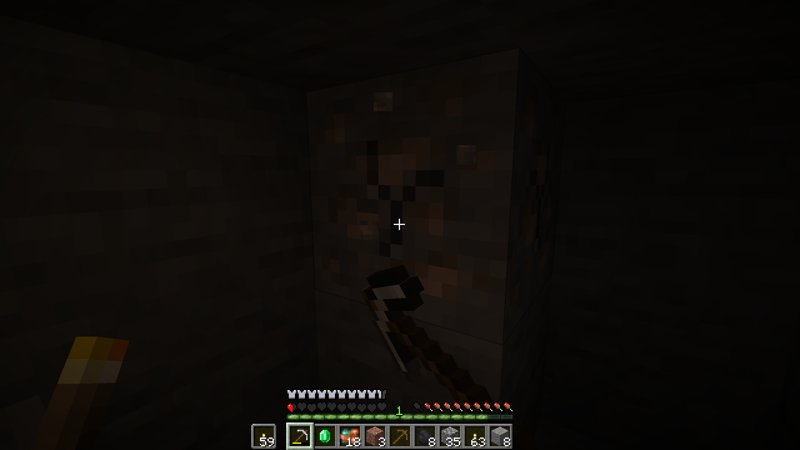

In [10]:
model.cpu()
model.eval()
img = Image.open("../data/compressed_images/mining (19).png")
preds = model(transforms.ToTensor()(img).unsqueeze(0))
preds

feature = "hearts"
print(ds.label_encoders[feature].inverse_transform(preds[feature].argmax(dim=1).cpu().detach().numpy()))

img

['building']


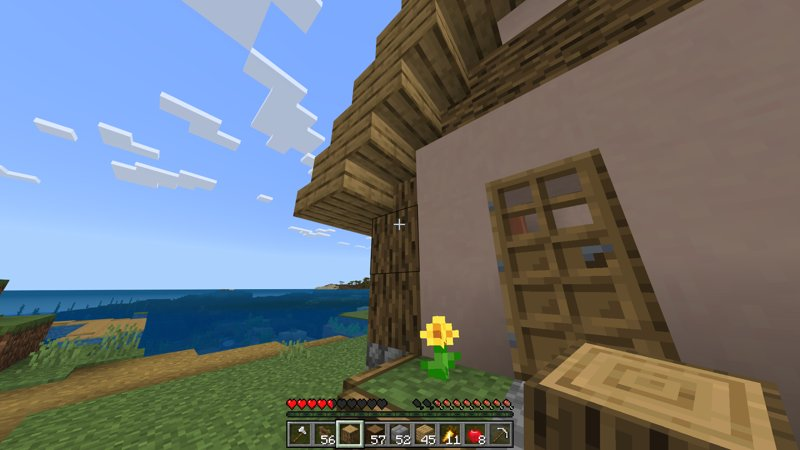

In [11]:
model.cpu()
img = Image.open("../data/compressed_images/building (119).png")
preds = model(transforms.ToTensor()(img).unsqueeze(0))
preds

feature = "activity"
print(ds.label_encoders[feature].inverse_transform(preds[feature].argmax(dim=1).cpu().detach().numpy()))

img

['high']


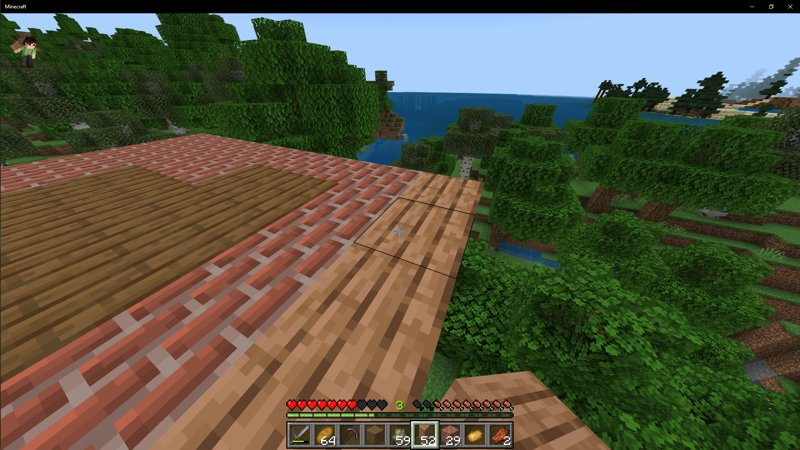

In [17]:
model.cpu()
img = Image.open("../screenshot.png")
preds = model(transforms.ToTensor()(img).unsqueeze(0))
preds

feature = "light_lvl"
print(ds.label_encoders[feature].inverse_transform(preds[feature].argmax(dim=1).cpu().detach().numpy()))

img